Loading Data

In [1]:
import re

# Load the book's text
with open('data/TKMBFullBook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

Cleaing book by spliting the chapters

In [2]:
chapters = re.split(r'Chapter \d+', text)
if chapters[0].strip() == "":
    chapters.pop(0) # Remove the empty string before the first chapter

Tokenizing by sentences and chunking by paragraphs

In [5]:
import nltk
nltk.download('punkt')   # run once

from nltk.tokenize import sent_tokenize

# WINDOW and STRIDE are now measured in sentences
WINDOW =100   # number of sentences per chunk (adjust to your needs)
STRIDE = 40  # shift in sentences for the next chunk
MIN_SENTENCES = 1  # minimum sentences to keep a final short chunk

def chapter_to_sentence_chunks(chapter_text, window=WINDOW, stride=STRIDE, min_sentences=MIN_SENTENCES):
    """
    Split chapter_text into overlapping chunks where each chunk is composed of whole sentences.
    Returns a list of dicts with 'text', 'sent_start', 'sent_end' (inclusive/exclusive indices).
    """
    sents = sent_tokenize(chapter_text.strip())
    chunks = []

    if not sents:
        return chunks

    for start in range(0, len(sents), stride):
        end = start + window
        # allow final shorter chunk (no 'break')
        chunk_sents = sents[start:end]
        if not chunk_sents:
            break
        # optionally skip tiny final chunks
        if len(chunk_sents) < min_sentences:
            continue

        chunk_text = " ".join(chunk_sents).strip()
        chunks.append({
            "text": chunk_text,
            "sent_start": start,
            "sent_end": min(end, len(sents)),  # exclusive
        })

        # Stop if we've reached the end
        if end >= len(sents):
            break

    return chunks

# Build the full corpus of chunks per chapter
all_chunks = []
for chap_num, chap_text in enumerate(chapters, start=1):
    chunks = chapter_to_sentence_chunks(chap_text, window=WINDOW, stride=STRIDE)
    for i, c in enumerate(chunks, start=1):
        all_chunks.append({
            "chapter": chap_num,
            "chunk_id": f"{chap_num}_{i}",
            "sent_start": c["sent_start"],
            "sent_end": c["sent_end"],
            "text": c["text"]
        })

print(f"Total chunks created: {len(all_chunks)}")
print("Example chunk:", all_chunks[0])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\salij\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total chunks created: 118
Example chunk: {'chapter': 1, 'chunk_id': '1_1', 'sent_start': 0, 'sent_end': 100, 'text': 'When he was nearly thirteen, my brother Jem got his arm badly broken at the \nelbow. When it healed, and Jem’s fears of never being able to play football were \nassuaged, he was seldom self-conscious about his injury. His left arm was \nsomewhat shorter than his right; when he stood or walked, the back of his hand \nwas at right angles to his body, his thumb parallel to his thigh. He couldn’t have \ncared less, so long as he could pass and punt. When enough years had gone by to enable us to look back on them, we \nsometimes discussed the events leading to his accident. I maintain that the Ewells \nstarted it all, but Jem, who was four years my senior, said it started long before \nthat. He said it began the summer Dill came to us, when Dill first gave us the idea \nof making Boo Radley come out. I said if he wanted to take a broad view of the thing, it really began with

Analysing chunk length distribution

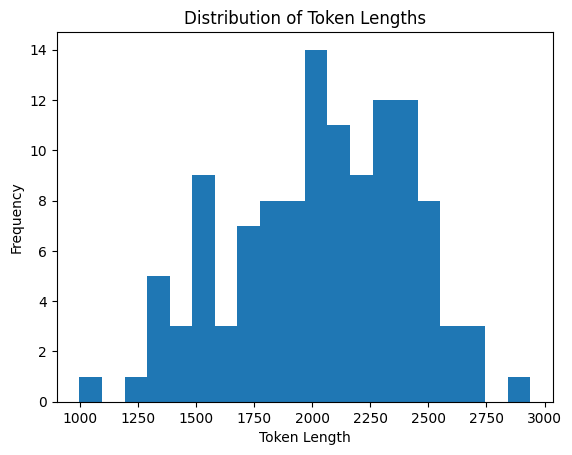

In [30]:
#TODO: Analyze the distribution of chunk lengths
import matplotlib.pyplot as plt

token_lengths = [len(word_tokenize(chunk['text'])) for chunk in all_chunks]
plt.hist(token_lengths, bins=20)
plt.xlabel('Token Length') # Length of each text chunk
plt.ylabel('Frequency') # Number of chunks with a given length
plt.title('Distribution of Token Lengths')
plt.show()

Lemmatization of words to increase model context

In [6]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text: str) -> list[str]:
    
      #normalizing curly apostrophes
    text = text.replace("’", "'").replace("‘", "'")
    # Removing multi-dots to a single space (...)
    text = re.sub(r'\.{2,}', ' ', text)
    # Replacing hyphens/slashes with spaces (so “cross-road” → “cross road”)
    text = re.sub(r'[-/]', ' ', text)
    # Removing all punctuation except apostrophes
    # Keeping letters, numbers, whitespace, and apostrophes for contractions/possessives
    text = re.sub(r"[^\w\s']+", '', text)
    # Normalizing whitespace and lowercasing
    text = re.sub(r'\s+', ' ', text).strip().lower()
    
    # Tokenize the text into words
    tokens = word_tokenize(text.lower())  # Convert to lowercase for consistency
    # Lemmatize each word
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Return the list of lemmatized tokens
    return lemmatized_tokens

Initializing BM25 model for retrieval

In [7]:
from rank_bm25 import BM25Okapi

# Create a list of lemmatized texts for BM25
Corpus = [lemmatize_text(chunk['text']) for chunk in all_chunks]

# Initialize BM25 with the corpus for ranking and retrieval
bm25 = BM25Okapi(Corpus)

Calling OpenAPI GPT model for text generation

In [8]:
import openai
from openai import OpenAI
import os

#  OpenAI API key

client = OpenAI(api_key = os.environ.get("OPENAI_API_KEY")) #Using environmental variable

#generate text
def generate_text(prompt: str) -> str:
    """Generates text using the OpenAI API based on the provided prompt."""
    
    # Make the API call
    response = client.chat.completions.create(
        model="gpt-4.1-mini",  
        messages=[{"role": "system", "content": "You are a creative short story writer who writes stories in a specified book/novel style and answer questions based on it."},
                  {"role": "user", "content": prompt}],
        temperature=0.7,  # Adjust temperature for creativity
    )
    
    return response.choices[0].message.content.strip()

In [43]:
generated_text = generate_text("In the novel 'To Kill a Mockingbird' what was happening to Jem?") 
print(generated_text)

In Harper Lee’s *To Kill a Mockingbird*, Jem Finch was going through a significant period of growth and change. As the story progresses, Jem is transitioning from childhood innocence to a more mature understanding of the complexities and injustices of the world around him. A pivotal moment occurs after the trial of Tom Robinson, which profoundly affects Jem. He becomes more introspective and sensitive to the harsh realities of racial prejudice and moral injustice in Maycomb. Physically, Jem is also growing; he is entering adolescence, which is symbolized by his increasing height and changing demeanor. This combination of emotional and physical changes marks Jem's journey from innocence toward a more nuanced awareness of human nature.


Getting the BM25 Scores for similar chapters in the book

In [44]:
processed_query = lemmatize_text(generated_text)

doc_scores = bm25.get_scores(processed_query)


doc_scores

array([ 98.7220466 ,  90.72477608,  96.47450683,  95.14690003,
        94.70372706, 103.06786598,  98.2969916 ,  99.44929065,
        99.01782965, 102.59853573,  99.39220491, 107.05644593,
        94.48971305,  89.87422017,  97.69095096,  97.5496668 ,
       104.8050023 ,  99.3182528 ,  97.19683528,  94.58532075,
        90.92454766,  97.23154182,  92.69201662, 104.65789982,
        98.27764103, 103.75771698, 101.2245161 ,  99.57127811,
        98.04281004,  95.74720237,  89.42983244, 112.91130489,
        99.33911987, 101.83368664,  96.15369127,  96.63515757,
       101.56038172, 109.2237855 , 104.85171126, 103.09376455,
       101.9626496 ,  91.61552912, 100.41757886, 104.05405183,
       100.06298042,  97.10875715, 100.41127465, 101.68354129,
        94.94807847, 100.47735925,  95.84878744,  98.20306462,
       100.72037095,  97.59938077, 110.31585604, 106.08249451,
       101.1409402 , 100.15149234,  92.45201639,  97.09579148,
        96.22743878,  87.21772156, 111.42336058, 110.01

In [45]:
# Get the top 2 indices (not the token lists)
top_indices = doc_scores.argsort()[-10:][::-1]  # Get indices of top 10 scores in descending order

print(f"Found top 2 matching chunks:\n")

for rank, idx in enumerate(top_indices):
    chunk = all_chunks[idx]
    bm25_score = doc_scores[idx]
    
    print(f"Rank {rank + 1}:")
    print(f"'chapter': {chunk['chapter']}, 'paragraph_Id': {chunk['chunk_id']}, 'bm25_score': {bm25_score:.4f}")
   # print(f"'text': {chunk['text']}")
    print("-" * 80)

Found top 2 matching chunks:

Rank 1:
'chapter': 9, 'paragraph_Id': 9_1, 'bm25_score': 112.9113
--------------------------------------------------------------------------------
Rank 2:
'chapter': 15, 'paragraph_Id': 15_1, 'bm25_score': 111.4234
--------------------------------------------------------------------------------
Rank 3:
'chapter': 28, 'paragraph_Id': 28_1, 'bm25_score': 111.1298
--------------------------------------------------------------------------------
Rank 4:
'chapter': 20, 'paragraph_Id': 20_2, 'bm25_score': 110.3944
--------------------------------------------------------------------------------
Rank 5:
'chapter': 13, 'paragraph_Id': 13_1, 'bm25_score': 110.3159
--------------------------------------------------------------------------------
Rank 6:
'chapter': 15, 'paragraph_Id': 15_2, 'bm25_score': 110.0198
--------------------------------------------------------------------------------
Rank 7:
'chapter': 10, 'paragraph_Id': 10_1, 'bm25_score': 109.2238
----------

Evaluation

In [33]:
import numpy as np
#calculate precision at k
def calculate_precision_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / k if k > 0 else 0.0

#calculate recall at k
def calculate_recall_at_k(retrieved, relevant, k):
    retrieved = retrieved[:k]
    relevant_set = set(relevant)
    num_relevant_retrieved = sum(1 for doc in retrieved if doc in relevant_set)
    return num_relevant_retrieved / len(relevant_set) if relevant_set else 0.0

#calculate f1 score at k
def calculate_f1_at_k(retrieved, relevant, k):
    precision = calculate_precision_at_k(retrieved, relevant, k)
    recall = calculate_recall_at_k(retrieved, relevant, k)
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0.0

#calculate MRR
def calculate_mrr(retrieved, relevant):
    mrr = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            mrr = 1 / (i + 1)
            break
    return mrr

#Calculate nDCG
def calculate_ndcg(retrieved, relevant):
    dcg = 0.0
    idcg = 0.0
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            dcg += 1 / (np.log2(i + 2))
    for i, doc in enumerate(relevant):
        idcg += 1 / (np.log2(i + 2))
    return dcg / idcg if idcg > 0 else 0.0

#calculate accuracy
def calculate_accuracy(retrieved, relevant):
    relevant_set = set(relevant)
    num_correct = sum(1 for doc in retrieved if doc in relevant_set)
    return num_correct / len(relevant_set) if relevant_set else 0.0

def calculate_map(retrieved, relevant, K):
    ap_sum = 0.0
    for i in range(1, K + 1):
        ap_sum += calculate_precision_at_k(retrieved, relevant, i)
    return ap_sum / K if K > 0 else 0.0

In [35]:
relevant_docs = {"1_1","7_1", "9_18", "12_1", "28_15","10_1", "26_8", "30_4", "11_8", "15_11"}  # relevant doc ids for a single query
# top_indices contains integer indices into all_chunks; use those to extract chunk_ids
retrieved_docs = [all_chunks[idx]["chunk_id"] for idx in top_indices]  # retrieved doc ids from the search results


In [36]:
print("Precision at k 5:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=5))
print("Precision at k 10:", calculate_precision_at_k(retrieved_docs, relevant_docs, k=10))

print("Recall at k 5:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=5))
print("Recall at k 10:", calculate_recall_at_k(retrieved_docs, relevant_docs, k=10))


print("F1 at k 5:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=5))
print("F1 at k 10:", calculate_f1_at_k(retrieved_docs, relevant_docs, k=10))

print("MAP:", calculate_map(retrieved_docs, relevant_docs, K=10))

print("MRR:", calculate_mrr(retrieved_docs, relevant_docs))
print("nDCG:", calculate_ndcg(retrieved_docs, relevant_docs))
print("Accuracy:", calculate_accuracy(retrieved_docs, relevant_docs))

Precision at k 5: 0.0
Precision at k 10: 0.1
Recall at k 5: 0.0
Recall at k 10: 0.1
F1 at k 5: 0.0
F1 at k 10: 0.10000000000000002
MAP: 0.047896825396825396
MRR: 0.14285714285714285
nDCG: 0.07336392209936005
Accuracy: 0.1


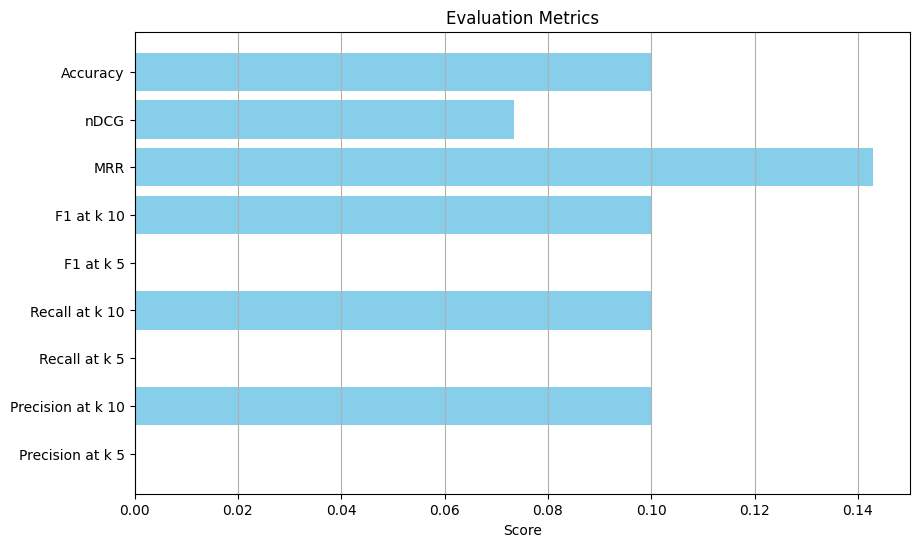

In [27]:
#plot the results including accuracy
import matplotlib.pyplot as plt

metrics = {
    "Precision at k 5": calculate_precision_at_k(retrieved_docs, relevant_docs, k=5),
    "Precision at k 10": calculate_precision_at_k(retrieved_docs, relevant_docs, k=10),
    "Recall at k 5": calculate_recall_at_k(retrieved_docs, relevant_docs, k=5),
    "Recall at k 10": calculate_recall_at_k(retrieved_docs, relevant_docs, k=10),
    "F1 at k 5": calculate_f1_at_k(retrieved_docs, relevant_docs, k=5),
    "F1 at k 10": calculate_f1_at_k(retrieved_docs, relevant_docs, k=10),
    "MRR": calculate_mrr(retrieved_docs, relevant_docs),
    "nDCG": calculate_ndcg(retrieved_docs, relevant_docs),
    "Accuracy": calculate_accuracy(retrieved_docs, relevant_docs)
}

plt.figure(figsize=(10, 6))
plt.barh(list(metrics.keys()), list(metrics.values()), color='skyblue')
plt.xlabel('Score')
plt.title('Evaluation Metrics')
plt.grid(axis='x')
plt.show()